In [3]:
import numpy as np
import os
import cv2
import h5py
import math
import time
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import prepare_data as pd

데이터 LR, HR 분리

In [5]:
# downdraded data 생성

def prepare_images(path, factor):
    
    # loop through the file in the directory 
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('downgraded/{}'.format(file), img)

In [6]:
prepare_images('./train', 2)

Saving baby_GT.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving head_GT.bmp
Saving woman_GT.bmp


데이터 전처리

      - train, test 데이터 가공

In [5]:
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale= 2

def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)     # data = zeros(14*30, 1, 32, 32)   이미지 단일화
    label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)    # label = zeros(14*30, 1, 20, 20)  이미지 단일화

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)         # Y컬러만 추출
        hr_img = hr_img[:, :, 0]
        
        # 저화질 이미지 생성 (행렬로만 이루어져 있음)
        w, h, c = shape
        new_height = int(h / scale)
        new_width = int(w / scale)
        lr_img = cv2.resize(hr_img, (new_height, new_width))         
        lr_img = cv2.resize(lr_img, (shape[1], shape[0])) 

        # random crop 할 때 자르는 범위 (좌표지정)
        Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)     
        Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)       
        
        # 패치 사이즈 만큼 cropping
        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]      
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]       

    return data, label

In [6]:
# train 데이터
train_data, train_label = prepare_data('./train/')
print(train_data.shape, train_label.shape)

# test 데이터
test_data, test_label = prepare_data('./test/')
print(test_data.shape, test_label.shape)

(45000, 1, 32, 32) (45000, 1, 20, 20)
(21000, 1, 32, 32) (21000, 1, 20, 20)


h5파일로 저장

In [7]:
def write_hdf5(data, labels, output_filename):

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()

In [8]:
# train, test 데이터 저장
write_hdf5(train_data, train_label, 'train.h5')
write_hdf5(test_data, test_label, 'test.h5')

train, test 데이터 불러오기

In [9]:
x_train, y_train = pd.read_training_data("train.h5")
x_val, y_val = pd.read_training_data("test.h5")

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(45000, 32, 32, 1) (45000, 20, 20, 1)
(21000, 32, 32, 1) (21000, 20, 20, 1)


Model

In [16]:
# define model type
SRCNN = Sequential()
    
 # add model layers
SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', input_shape=(None, None, 1)))
SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same'))
SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid'))

# SRCNN.summary()
SRCNN.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [23]:
# 모델 훈련
start = time.time()
SRCNN.fit(x_train, y_train, batch_size=64, shuffle=True, epochs=100, verbose=1, validation_data=(x_val, y_val))
end = time.time() - start
print("걸린 시간 : ", round(end, 2))

Epoch 1/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 3/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 7/100
704/704 [==============================] - 5s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/100
704/704 [==============================] - 5s 7ms/step - 

Evaluate

In [24]:
# define function for peak signal-to-noise ration (PSNR)
def psnr(target, ref) : 
    
    # assume RGB/BGR image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255./ rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    
    # MSE is the sum of the squared fifference between the two the images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel= True))
    
    return scores

Predict

In [25]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border:-border, border:-border]
    return img

In [26]:
def predict(image_path):
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('train/{}'.format(file))
    
    # preprocess the image with madcrop
    ref = modcrop(ref, 2)
    degraded = modcrop(degraded, 2)
    
    # convert the image to VCrCb - (srccn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = SRCNN.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR) 
    
    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality caluclations 
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores  

Degraded Image : 
PSNR: 25.37652772658602
MSE: 565.6513694933549
SSIM: 0.7967745679279545

Reconstructed Image : 
PSNR: 26.877399236249566
MSE: 400.3701511165081
SSIM: 0.8447495991983035



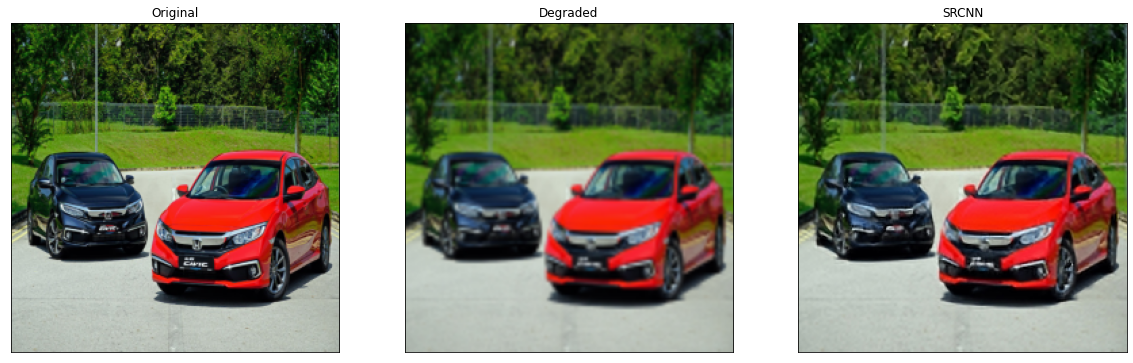

In [27]:
ref, degraded, output, scores = predict('downgraded/0.png')

# print all scores for all images
print('Degraded Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image : \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title("Degraded")
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title("SRCNN")

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [22]:
# cv2.imwrite('SRCNN car.jpg', output)
# cv2.imwrite('Raw car.jpg', ref)
# cv2.imwrite('Degraded car.jpg', degraded)